# Arabic Dialects Code
Done By: Ameera Attiah


## Downloading Libraries

In [ ]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 114.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
from datasets import load_dataset
import torch, torchvision, torchaudio, datasets
import numpy as np
import transformers

print("numpy version: ",np.__version__)  # should be 1.26.4

numpy version:  1.26.4


## Benchmark Dataset (18 Dialects + MSA)

In [ ]:
!mkdir qadi_data
!wget -O qadi_data/train.parquet https://huggingface.co/datasets/Abdelrahman-Rezk/Arabic_Dialect_Identification/resolve/main/data/train-00000-of-00001.parquet
!wget -O qadi_data/validation.parquet https://huggingface.co/datasets/Abdelrahman-Rezk/Arabic_Dialect_Identification/resolve/main/data/validation-00000-of-00001.parquet
!wget -O qadi_data/test.parquet https://huggingface.co/datasets/Abdelrahman-Rezk/Arabic_Dialect_Identification/resolve/main/data/test-00000-of-00001.parquet
!wget https://huggingface.co/datasets/EMINES/summarized-darija-msa-wiki-data/resolve/main/data/train-00000-of-00001.parquet -O msa.parquet

--2025-07-22 09:18:36--  https://huggingface.co/datasets/Abdelrahman-Rezk/Arabic_Dialect_Identification/resolve/main/data/train-00000-of-00001.parquet
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.88, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/74/25/74257037d4c9953dc8b4b5c3b1c269519c923ab99eaa1ed809c499d2103b6178/1a462291eac6e57b4bec738e6bcc92f23b626a6a1d6a7f744ba50974b869c9a7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27train-00000-of-00001.parquet%3B+filename%3D%22train-00000-of-00001.parquet%22%3B&Expires=1753179516&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MzE3OTUxNn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy83NC8yNS83NDI1NzAzN2Q0Yzk5NTNkYzhiNGI1YzNiMWMyNjk1MTljOTIzYWI5OWVhYTFlZDgwOWM0OTlkMjEwM2I2MTc4LzFhNDYyMjkxZWFjNmU1N2I0YmVjNzM4ZTZiY2M5

In [ ]:
from datasets import Dataset, DatasetDict, ClassLabel, Features, Value
import pandas as pd
import random
import os

# Load QADI parquet files using pandas
train_df = pd.read_parquet("qadi_data/train.parquet")
val_df   = pd.read_parquet("qadi_data/validation.parquet")
test_df  = pd.read_parquet("qadi_data/test.parquet")

# Convert to Hugging Face Datasets
qadi = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

print(f"✅ Loaded QADI manually: {len(qadi['train'])} training samples.")

# Define original dialect/country labels from the QADI paper
dialect_labels = [
    "OM", # Omani Arabic
    "SD", # Suadanese Arabic
    "SA", # Najdi/ Saudi Arabic
    "KW", # Kuwaiti Arabic
    "QA", # Qatari Arabic
    "LB", # Lebanese Arabic
    "JO", # Jordanian Arabic
    "SY", # Syrian Arabic
    "IQ", # Iraqi Arabic
    "MA", # Moroccan Arabic
    "EG", # Egyptian Arabic
    "PL", # Palestinian Arabic
    "YE", # Yemeni Arabic
    "BH", # Bahrani Arabic
    "DZ", # Algerian Arabic
    "AE", # Emirati Arabic
    "TN", # Tunisian Arabic
    "LY"  # Libyan Arabic
]

# Add new label for MSA (Modern Standard Arabic)
full_labels = dialect_labels + ["MSA"]

print("📖 Reading and filtering MSA rows...")
msa_df = pd.read_parquet("msa.parquet")
msa_df = msa_df[msa_df["category"].str.lower() == "msa"]
msa_df = msa_df[msa_df["text"].str.len() >= 30]
msa_df = msa_df[["text"]].copy()
msa_df["label"] = 18  # Label for MSA

print(f"✅ Collected {len(msa_df)} MSA samples from EMINES dataset.")

# Convert QADI train to pandas and merge with MSA
qadi_train_df = pd.DataFrame(qadi["train"])
combined_train_df = pd.concat([qadi_train_df, msa_df]).sample(frac=1, random_state=42)

# Convert back to HF Dataset
combined_train_dataset = Dataset.from_pandas(combined_train_df.reset_index(drop=True)).shuffle(seed=42)

# Define full feature schema with ClassLabel
features = Features({
    "id": Value("int64"),
    "text": Value("string"),
    "label": ClassLabel(num_classes=19, names=full_labels)
})

# Apply label schema to all splits (only train has MSA added)
qadi["train"] = combined_train_dataset.cast(features)
qadi["validation"] = qadi["validation"].cast(features)
qadi["test"] = qadi["test"].cast(features)

print(f"🔁 Final training set: {len(qadi['train'])} samples across {len(qadi['train'].features['label'].names)} classes.")
print(f"✅ Label names: {qadi['train'].features['label'].names}")


✅ Loaded QADI manually: 440052 training samples.
📖 Reading and filtering MSA rows...
✅ Collected 3000 MSA samples from EMINES dataset.


Casting the dataset:   0%|          | 0/443052 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9164 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/8981 [00:00<?, ? examples/s]

🔁 Final training set: 443052 samples across 19 classes.
✅ Label names: ['OM', 'SD', 'SA', 'KW', 'QA', 'LB', 'JO', 'SY', 'IQ', 'MA', 'EG', 'PL', 'YE', 'BH', 'DZ', 'AE', 'TN', 'LY', 'MSA']


## 4 Arabic BERT Models (just testing the code if it works)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import torch
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

os.environ["WANDB_DISABLED"] = "true"

# 🧪 Choose classifier models to benchmark
model_names = {
    "AraBERTv02": "aubmindlab/bert-base-arabertv02",
    "CAMeLBERT-DA": "CAMeL-Lab/bert-base-arabic-camelbert-da",
    "MARBERT": "UBC-NLP/MARBERT",
    "mBERT": "google-bert/bert-base-multilingual-cased"
}

# 📊 Metric computation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# 📤 Prepare dataset with tokenization
def tokenize_dataset(model_name, dataset, label_count):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    def tokenize(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)
    tokenized = dataset.map(tokenize, batched=True)
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized, tokenizer

# 🧪 Run training + evaluation for each model
results = {}

for name, model_id in model_names.items():
    print(f"\n🚀 Training {name}...")

    tokenized_ds, tokenizer = tokenize_dataset(model_id, qadi, label_count=19)

    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=19)


    training_args = TrainingArguments(
        output_dir=f"./results_{name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=1,
        report_to="none",
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()
    results[name] = eval_result

print("\n✅ Summary of Macro F1-scores:")
for name, res in results.items():
    print(f"{name}: F1-macro = {res['eval_f1_macro']:.4f}, Accuracy = {res['eval_accuracy']:.4f}")



🚀 Training AraBERTv02...


Map:   0%|          | 0/443052 [00:00<?, ? examples/s]

Map:   0%|          | 0/9164 [00:00<?, ? examples/s]

Map:   0%|          | 0/8981 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.247900,1.145426,0.644138,0.618657
2,1.016400,1.000133,0.693464,0.665752
3,0.842400,0.948620,0.710277,0.685434



🚀 Training CAMeLBERT-DA...


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/443052 [00:00<?, ? examples/s]

Map:   0%|          | 0/9164 [00:00<?, ? examples/s]

Map:   0%|          | 0/8981 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.180700,1.144724,0.641688,0.613837
2,0.923900,0.995865,0.690346,0.663971
3,0.706100,0.979071,0.711836,0.687562


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]


🚀 Training MARBERT...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/443052 [00:00<?, ? examples/s]

Map:   0%|          | 0/9164 [00:00<?, ? examples/s]

Map:   0%|          | 0/8981 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.940800,0.893065,0.729651,0.705645
2,0.657600,0.834949,0.754704,0.733981


model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.940800,0.893065,0.729651,0.705645
2,0.657600,0.834949,0.754704,0.733981
3,0.406700,0.897350,0.757377,0.736812



🚀 Training mBERT...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/443052 [00:00<?, ? examples/s]

Map:   0%|          | 0/9164 [00:00<?, ? examples/s]

Map:   0%|          | 0/8981 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.262600,1.178667,0.641243,0.577423
2,1.033300,1.015713,0.694689,0.667160
3,0.831800,0.958695,0.714731,0.690827



✅ Summary of Macro F1-scores:
AraBERTv02: F1-macro = 0.6854, Accuracy = 0.7103
CAMeLBERT-DA: F1-macro = 0.6876, Accuracy = 0.7118
MARBERT: F1-macro = 0.7368, Accuracy = 0.7574
mBERT: F1-macro = 0.6908, Accuracy = 0.7147


## 12 Arabic BERT Models


🚀 Training CAMeLBERT-DA...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/443052 [00:00<?, ? examples/s]

Map:   0%|          | 0/9164 [00:00<?, ? examples/s]

Map:   0%|          | 0/8981 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.173900,1.136436,0.640129,0.611690
2,0.924400,0.987981,0.695357,0.667237
3,0.707000,0.976487,0.708830,0.686547



📊 CAMeLBERT-DA Evaluation Results:
   - Accuracy:  0.7088
   - F1-macro:  0.6865
Generating confusion matrix...


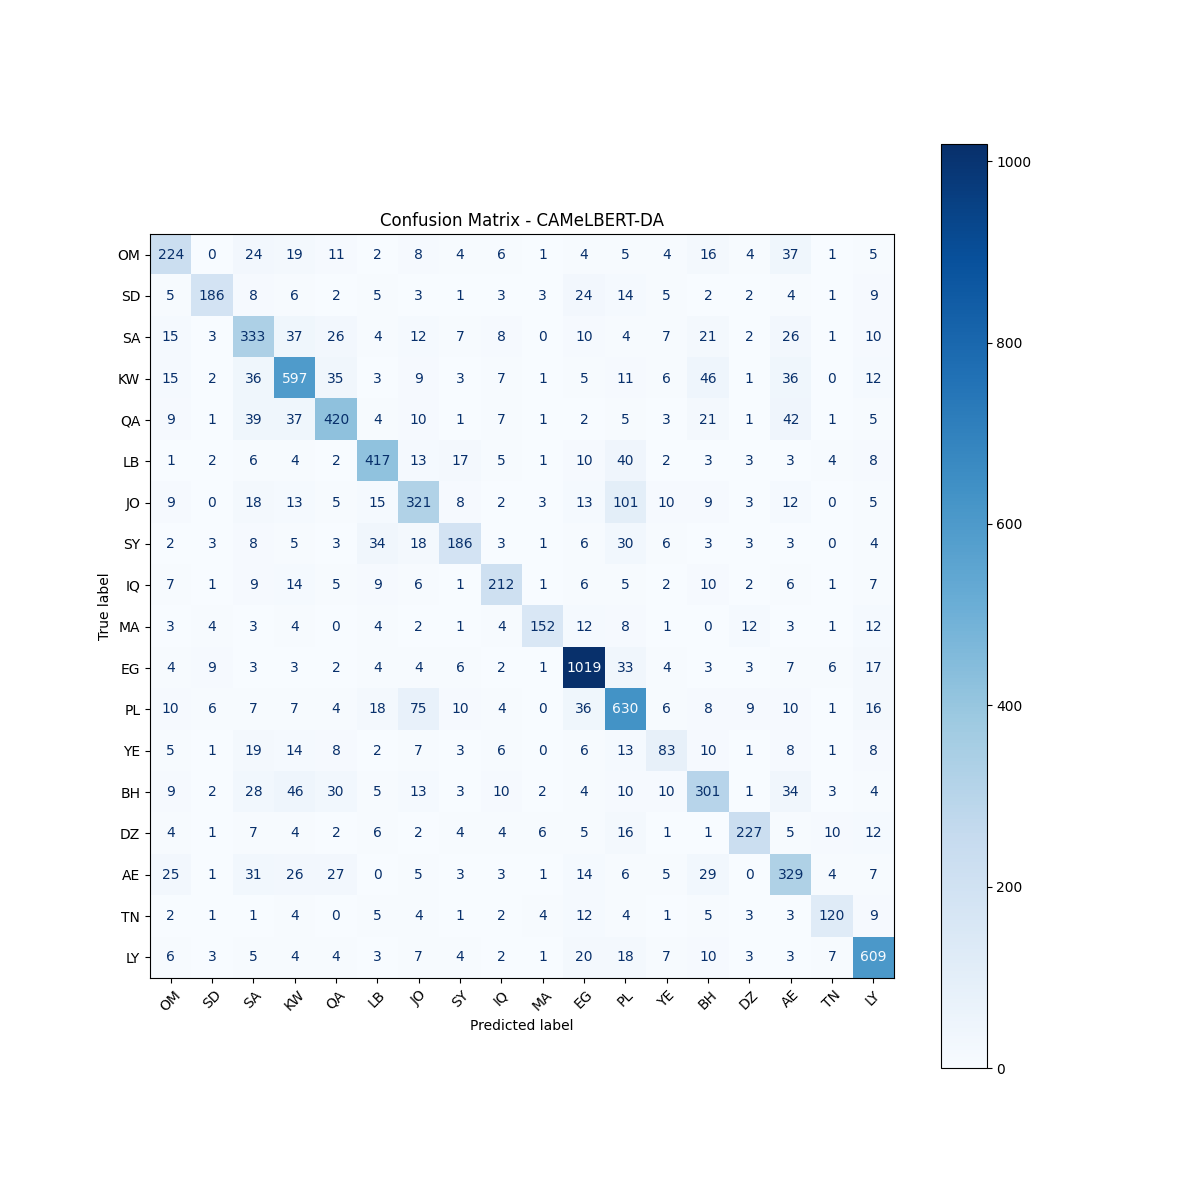


✅ Summary of Macro F1-scores:
CAMeLBERT-DA: F1-macro = 0.6865, Accuracy = 0.7088


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
from pathlib import Path

os.environ["WANDB_DISABLED"] = "true"

# Choose classifier models to benchmark
model_names = {
    # "mBERT": "bert-base-multilingual-cased",
    # "AraBERTv02": "aubmindlab/bert-base-arabertv02",
    # "ARBERT": "UBC-NLP/ARBERT",
    # "MARBERT": "UBC-NLP/MARBERT",
    # "ArabicBERT": "asafaya/bert-base-arabic",
    # "QARiB": "ahmedabdelali/bert-base-qarib",
    # "GigaBERT": "lanwuwei/GigaBERT-v4-Arabic-and-English",
    # "XLM-R": "FacebookAI/xlm-roberta-base",
    # "ALBERT-Arabic": "asafaya/albert-base-arabic",
    # "MultiDialectBERT": "bashar-talafha/multi-dialect-bert-base-arabic",
    # "CAMeLBERT-Mix": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
    "CAMeLBERT-DA": "CAMeL-Lab/bert-base-arabic-camelbert-da"
}


# Confusion Matrix function
def plot_confusion_matrix(labels, preds, class_names, model_name):
    print("Generating confusion matrix...")
    cm = confusion_matrix(labels, preds)
    used_class_indices = np.unique(np.concatenate([labels, preds]))
    used_class_names = [class_names[i] for i in used_class_indices]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=used_class_names)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"./results_{model_name}/confusion_matrix_{model_name}.png")
    plt.close()



# Metric computation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# Prepare dataset with tokenization
def tokenize_dataset(model_name, dataset, label_count):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    def tokenize(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)
    tokenized = dataset.map(tokenize, batched=True)
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized, tokenizer

# Run training + evaluation for each model
results = {}

for name, model_id in model_names.items():
    print(f"\n🚀 Training {name}...")

    tokenized_ds, tokenizer = tokenize_dataset(model_id, qadi, label_count=19)

    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=19)


    training_args = TrainingArguments(
        output_dir=f"./results_{name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=1,
        report_to="none",
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        compute_metrics=compute_metrics
    )
    checkpoint_path = Path(f"./results_{name}")
    if any(checkpoint_path.glob("checkpoint-*")):
        trainer.train(resume_from_checkpoint=True)
    else:
        trainer.train()
    eval_result = trainer.evaluate()
    results[name] = eval_result

    # Print evaluation result immediately
    print(f"\n📊 {name} Evaluation Results:")
    print(f"   - Accuracy:  {eval_result.get('eval_accuracy', 'N/A'):.4f}")
    print(f"   - F1-macro:  {eval_result.get('eval_f1_macro', 'N/A'):.4f}")


    output_path = Path(f"./results_{name}")
    output_path.mkdir(parents=True, exist_ok=True)

    with open(output_path / "metrics.json", "w") as f:
        json.dump(eval_result, f, indent=4)

    # Get predictions
    predictions = trainer.predict(tokenized_ds["test"])
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Plot confusion matrix
    class_names = qadi["train"].features["label"].names  # assumes dataset has label names
    plot_confusion_matrix(labels, preds, class_names, model_name=name)

    from IPython.display import Image, display
    display(Image(filename=f"./results_{name}/confusion_matrix_{name}.png"))


print("\n✅ Summary of Macro F1-scores:")
for name, res in results.items():
    print(f"{name}: F1-macro = {res['eval_f1_macro']:.4f}, Accuracy = {res['eval_accuracy']:.4f}")


In [ ]:
!zip -r /content/all_results.zip /content -x "/content/sample_data/*"


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.07.16/ (stored 0%)
  adding: content/.config/logs/2025.07.16/13.47.19.800388.log (deflated 58%)
  adding: content/.config/logs/2025.07.16/13.47.49.863054.log (deflated 56%)
  adding: content/.config/logs/2025.07.16/13.47.36.852800.log (deflated 57%)
  adding: content/.config/logs/2025.07.16/13.46.49.213464.log (deflated 92%)
  adding: content/.config/logs/2025.07.16/13.47.31.634017.log (deflated 86%)
  adding: content/.config/logs/2025.07.16/13.47.48.882615.log (deflated 57%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_da

In [ ]:
from google.colab import files
files.download("/content/all_results.zip")


FileNotFoundError: Cannot find file: /content/all_results.zip